# 0.0 Imports

In [135]:
import pandas as pd
import numpy  as np

import inflection
import datetime
import random

import seaborn as sns
import sweetviz as sv
import scikitplot as skplt

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML

from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn  import model_selection as ms
from sklearn  import preprocessing   as pp
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from sklearn  import linear_model    as lm
from xgboost  import XGBClassifier   as xgb
from lightgbm import LGBMClassifier

## 0.1 Helper functions

In [194]:
def rename_columns(dataframe):
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    return df

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.set_option('max_columns', None, "max_rows", 50)
    pd.options.display.max_rows = 999
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def precision_recall_at_k(yhat_proba, y_val, k=2000):
    ''' receives the response probability and the validation response (or test)
    returns:
    - a tuple with precision and recall at k
    - a table with all the metrics '''
    
    table_proba = pd.DataFrame(yhat_proba)

    # add the 'response' column
    table_proba['target'] = y_val.values

    # sorting values of the correct probability column
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']


    # Precision and Recall at K
    table_proba = table_proba.reset_index (drop=True)

    # create ranking order
    table_proba['ranking'] = table_proba.index + 1

    # calculate precision and recall
    table_proba['precision_at_k'] = table_proba['target'].cumsum() / table_proba['ranking']
    table_proba['recall_at_k'] = table_proba['target'].cumsum() / table_proba['target'].sum()

    precision_at_k = table_proba.loc[k-1, 'precision_at_k']

    recall_at_k = table_proba.loc[k-1, 'recall_at_k']

    return((precision_at_k, recall_at_k), table_proba)

def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

def cross_validation(model, model_name, x_train, y_train, k_top, kfolds, verbose=False):
    # X separate X and Y data:
    xtraining = x_train
    ytraining = y_train
    
    # cross-validation:
    cv = StratifiedKFold(n_splits=kfolds)
    prec_k_list = []
    rec_k_list = []
    i = 1
    for train_index, prim_val_index in cv.split(xtraining, ytraining):
        if verbose:
            print(f'Fold number {i}/{kfolds}')
        else:
            pass
                
        X_training, X_prim_val = xtraining.iloc[train_index], xtraining.iloc[prim_val_index]
        y_training, y_prim_val = ytraining.iloc[train_index], ytraining.iloc[prim_val_index]
        
        # remove id from training, and create new validation without id
        X_training = X_training
        X_prim_val_no_id = X_prim_val
        
        # fit and predict_proba
        model.fit(X_training, y_training)
        yhat_proba = model.predict_proba(X_prim_val_no_id)
        
        metrics, table = precision_recall_at_k(yhat_proba, y_prim_val, k_top)
        
        # transform yhat_proba to 1D-array
        ##yhat_proba_1d = yhat_proba[:, 1].tolist()
        
        # reconstruct dataframe
        ##prim_val = pd.concat([X_prim_val, y_prim_val], axis=1)
        ##prim_val['score'] = yhat_proba_1d
        ##prim_val = prim_val.sort_values('score', ascending=False)
        
        # evaluate accuracy and store in list
        ##prec_k_list.append(precision_at_k(prim_val, k_top))
        ##rec_k_list.append(recall_at_k(prim_val, k_top))
        
        prec_k_list.append(metrics[0])
        rec_k_list.append(metrics[1])
        
        i+=1
    
    #evaluate mean and std
    prec_k_pred = np.round(np.mean(prec_k_list), 4).astype(str) + '+/-' + np.round(np.std(prec_k_list), 4).astype(str)
    rec_k_pred = np.round(np.mean(rec_k_list), 4).astype(str) + '+/-' + np.round(np.std(rec_k_list), 4).astype(str)
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':prec_k_pred,
                         'recall_at_k':rec_k_pred}, index=[0])


In [11]:
jupyter_settings()

## 0.2 Loading data

In [12]:
df_raw_train = pd.read_csv('../data/train.csv')
df_raw_test = pd.read_csv('../data/test.csv')

# 1.0 Data description

In [13]:
df1 = df_raw_train.copy()

## 1.1 Rename columns

In [14]:
# Using the function we created in section 0.1
df1 = rename_columns(df1)

## 1.2 Data dimensions

In [15]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3 Data types

In [16]:
df1.sample(20)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
329282,329283,Male,20,1,44.0,0,< 1 Year,Yes,2630.0,160.0,229,0
293999,294000,Male,41,1,28.0,0,1-2 Year,Yes,70914.0,124.0,180,0
261235,261236,Female,22,1,11.0,1,< 1 Year,No,27351.0,152.0,181,0
196350,196351,Female,63,1,35.0,0,1-2 Year,Yes,2630.0,157.0,269,0
86037,86038,Female,26,1,28.0,1,< 1 Year,No,2630.0,1.0,174,0
319760,319761,Male,43,1,8.0,0,1-2 Year,No,44232.0,124.0,224,0
300748,300749,Female,39,1,30.0,1,1-2 Year,No,32439.0,122.0,35,0
353559,353560,Female,41,1,8.0,0,> 2 Years,Yes,2630.0,26.0,216,0
287920,287921,Male,44,1,27.0,1,1-2 Year,No,29695.0,26.0,65,0
128747,128748,Male,32,1,41.0,1,< 1 Year,No,34580.0,152.0,148,0


In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA 

## 1.6 Change Types

In [19]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1[['id', 'age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel', 'region_code', 'response']]

### 1.7.1 Numerical attributes

In [21]:
df_aux = num_attributes.describe().T[['min', 'max', 'mean', 'std']]
range_ = df_aux['min'] - df_aux['max']
kurt = num_attributes.kurt(axis=0)
skew = num_attributes.skew(axis=0)

df_aux['range'] = range_
df_aux['kurt'] = kurt
df_aux['skew'] = skew

df_aux

,min,max,mean,std,range,kurt,skew
id,1.0,381109.0,190555.000000,110016.836208,-381108.0,-1.200000,9.443274e-16
age,20.0,85.0,38.822584,15.511611,-65.0,-0.565655,6.725390e-01
annual_premium,2630.0,540165.0,30564.389581,17213.155057,-537535.0,34.004569,1.766087e+00
vintage,10.0,299.0,154.347397,83.671304,-289.0,-1.200688,3.029517e-03


### 1.7.2 Categorical attributes

In [22]:
cat_attributes

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage,policy_sales_channel,region_code,response
0,Male,1,0,> 2 Years,Yes,26,28,1
1,Male,1,0,1-2 Year,No,26,3,0
2,Male,1,0,> 2 Years,Yes,26,28,1
3,Male,1,1,< 1 Year,No,152,11,0
4,Female,1,1,< 1 Year,No,152,41,0
...,...,...,...,...,...,...,...,...
381104,Male,1,1,1-2 Year,No,26,26,0
381105,Male,1,1,< 1 Year,No,152,37,0
381106,Male,1,1,< 1 Year,No,160,30,0
381107,Female,1,0,> 2 Years,Yes,124,14,0


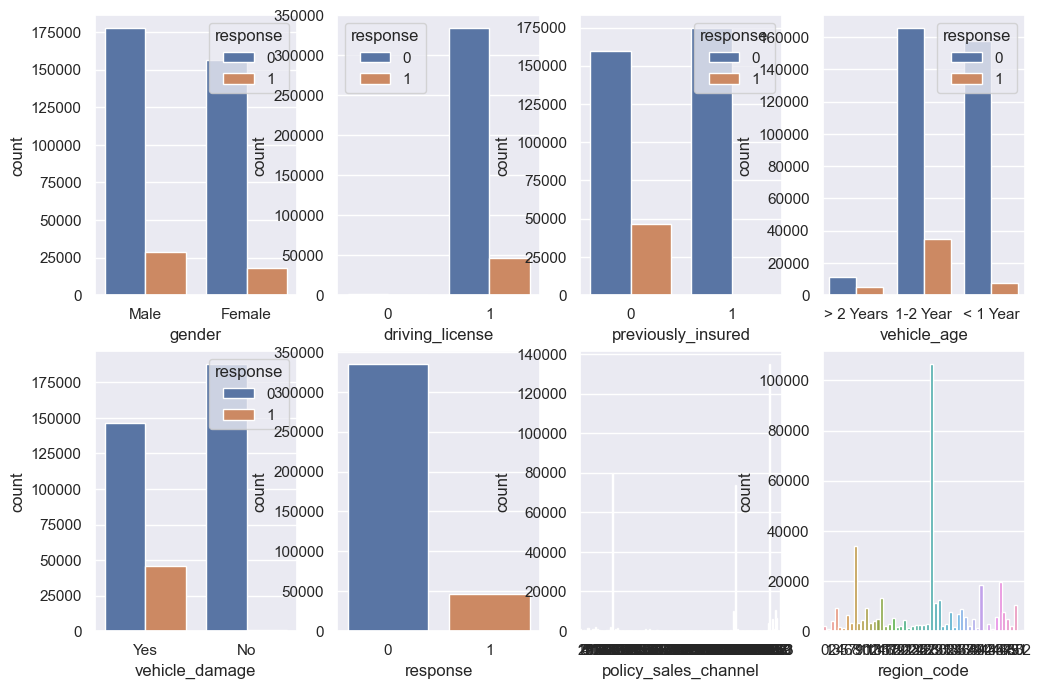

In [23]:
aux = df1.copy()

plt.subplot(2, 4, 1)
sns.countplot(x='gender', hue='response', data=aux);

plt.subplot(2, 4, 2)
sns.countplot(x='driving_license', hue='response', data=aux);

plt.subplot(2, 4, 3)
sns.countplot(x='previously_insured', hue='response', data=aux);

plt.subplot(2, 4, 4)
sns.countplot(x='vehicle_age', hue='response', data=aux);

plt.subplot(2, 4, 5)
sns.countplot(x='vehicle_damage', hue='response', data=aux);

plt.subplot(2, 4, 6)
sns.countplot(x='response', data=aux);

plt.subplot(2, 4, 7)
sns.countplot(x='policy_sales_channel', data=aux);

plt.subplot(2, 4, 8)
sns.countplot(x='region_code', data=aux);

# 2.0 Feature engineering

In [24]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipoteses

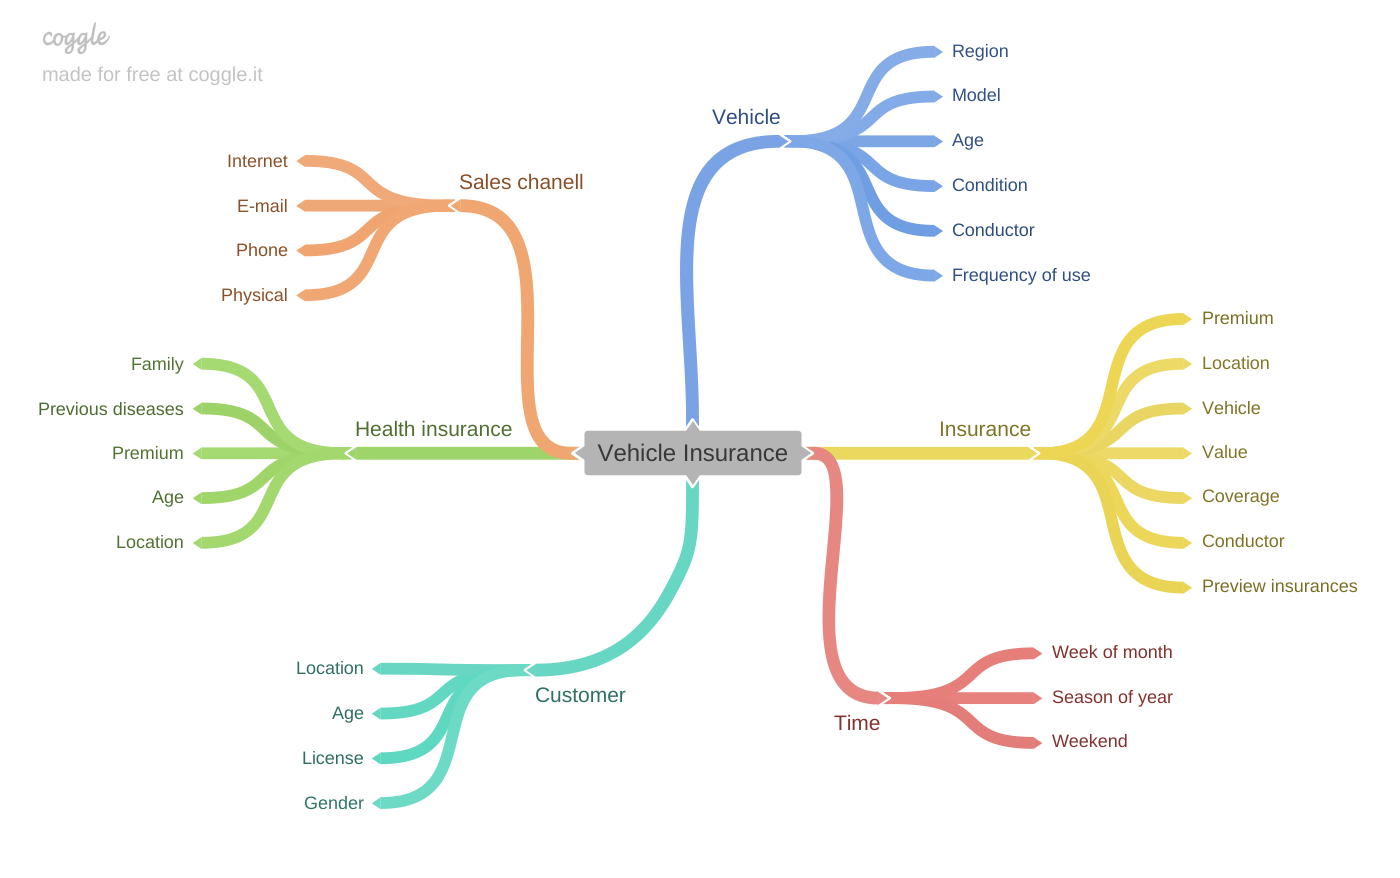

## 2.2 Criação de Hipoteses

- Vehicles
    - Vehicle with higher are have more probability to adquire insurance
    - Vehicles that got damaged have more probability to adquire insurance
    - Vehicles that already had an insurance have more probability to adquire insurance
    
    
- Health Insurance
    - Higher premium have more probability to adquire insurance
    - More days associeted have more probability to adquire insurance
    
- Customer
    - Higher age have more probability to adquire insurance
    - Female gender have more probability to adquire insurance
    - Dangerous location have more probability to adquire insurance
    
- Time - no data available
- Insurance - no data available
- Sales channel - no data available
    

## 2.3 Splitting dataset

In [25]:
X = df2.drop('response', axis=1).copy()
y = df2['response'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 42)

df2 = pd.concat([X_train, y_train], axis=1)

df_test = pd.concat([X_test, y_test], axis=1)

## 2.4 Feature engineering

In [26]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,Yes,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,No,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,Yes,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,Yes,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,Yes,48706.0,156,222,0


In [27]:
df2['vehicle_damage'].unique()

array(['Yes', 'No'], dtype=object)

In [28]:
damage = {'Yes': 1, 'No':0}

df2['vehicle_damage'] = df2['vehicle_damage'].map(damage)

# 3.0 Feature filtering

In [29]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

## 3.2 Seleção das colunas

# 4.0 EDA - Análise exploratória dos dados

In [30]:
df4 = df3.copy()

In [31]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,48706.0,156,222,0


## 4.1 Análise univariada

### 4.1.1 Response variable

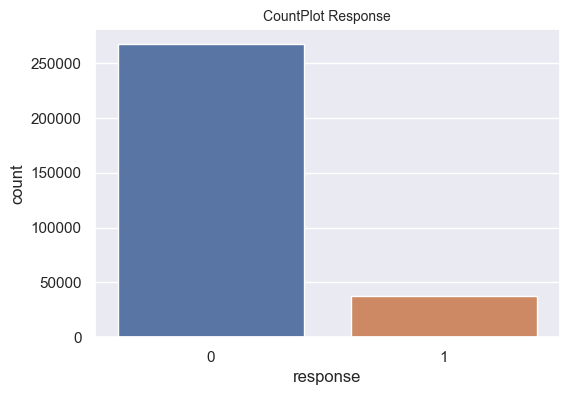

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df2, x='response', ax=ax)
ax.set_title("CountPlot Response", fontsize=10);

In [33]:
response_count = {
    'count':[len(df4[df4['response']==0]), len(df4[df4['response']==1])],
}
df_response = pd.DataFrame.from_dict(response_count)
df_response['percent'] = df_response['count'] / len(df4)
df_response

,count,percent
0,267519,0.877437
1,37368,0.122563


### 4.1.2 Numerical variable

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_16572\2533347166.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df4.hist(ax=ax, bins= 10);


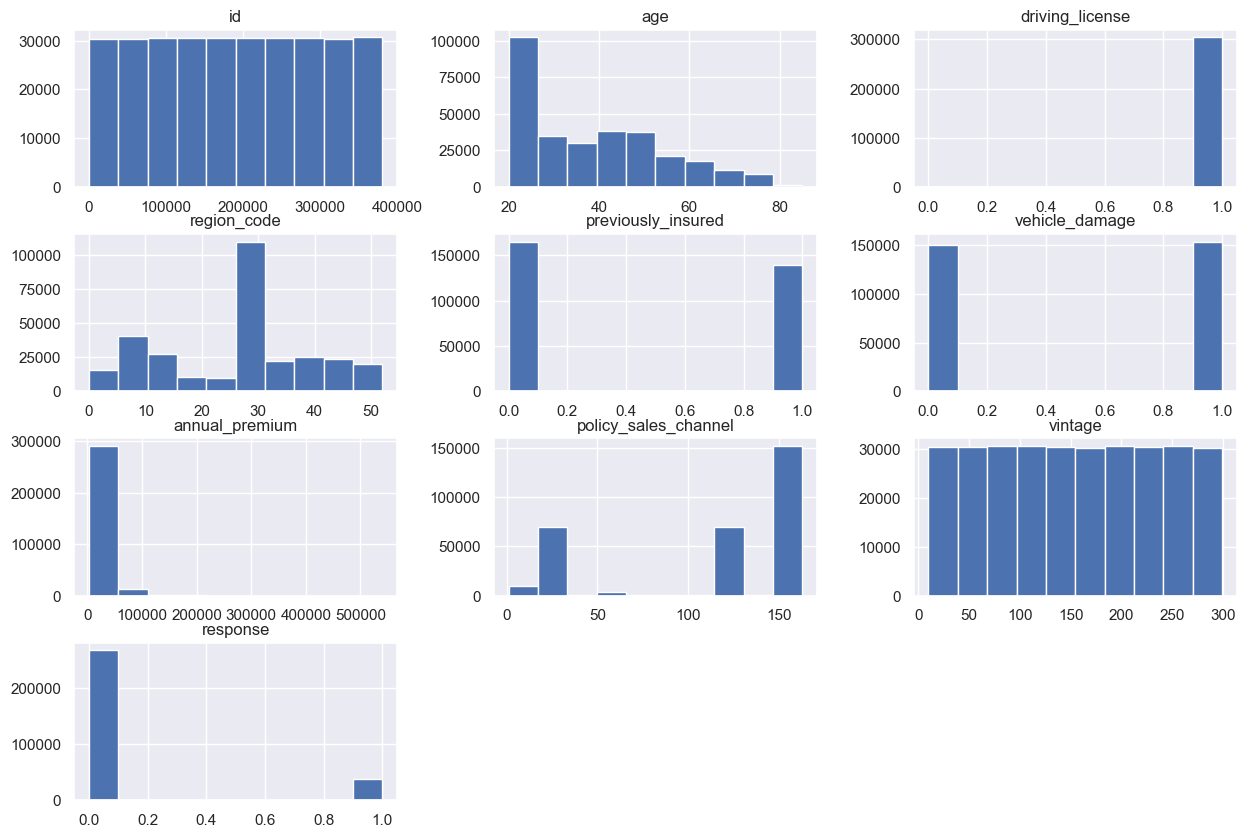

In [34]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df4.hist(ax=ax, bins= 10);

### 4.1.3 Categorical variable

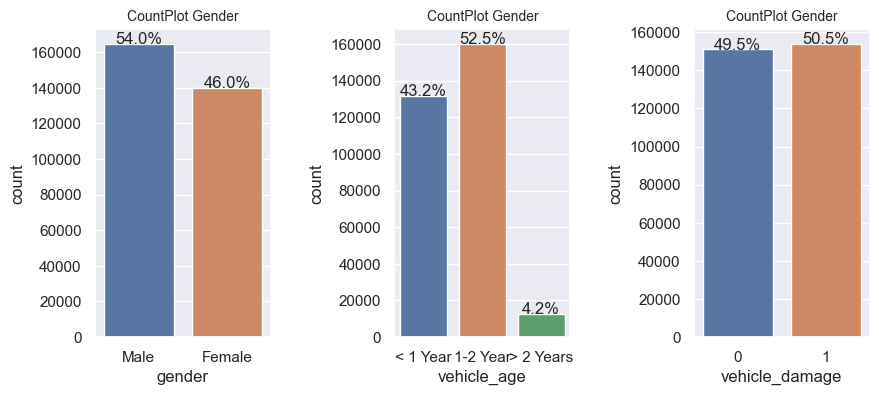

In [35]:
# gender
fig, ax = plt.subplots(1,3, figsize=(10,4))

sns.countplot(data=df4, x='gender', ax=ax[0])
ax[0].set_title("CountPlot Gender", fontsize=10);
for p in ax[0].patches:
            height = p.get_height()
            ax[0].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")
            
# vehicle_age
sns.countplot(data=df4, x='vehicle_age', ax=ax[1])
ax[1].set_title("CountPlot Gender", fontsize=10);
for p in ax[1].patches:
            height = p.get_height()
            ax[1].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")

# vehicle_damage
sns.countplot(data=df4, x='vehicle_damage', ax=ax[2])
ax[2].set_title("CountPlot Gender", fontsize=10);
for p in ax[2].patches:
            height = p.get_height()
            ax[2].text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df4)*100), ha="center")
            
plt.subplots_adjust(wspace=0.7)

## 4.2 Análise bivariada

* Vehicles 
    - Vehicle with higher age have more probability to adquire insurance

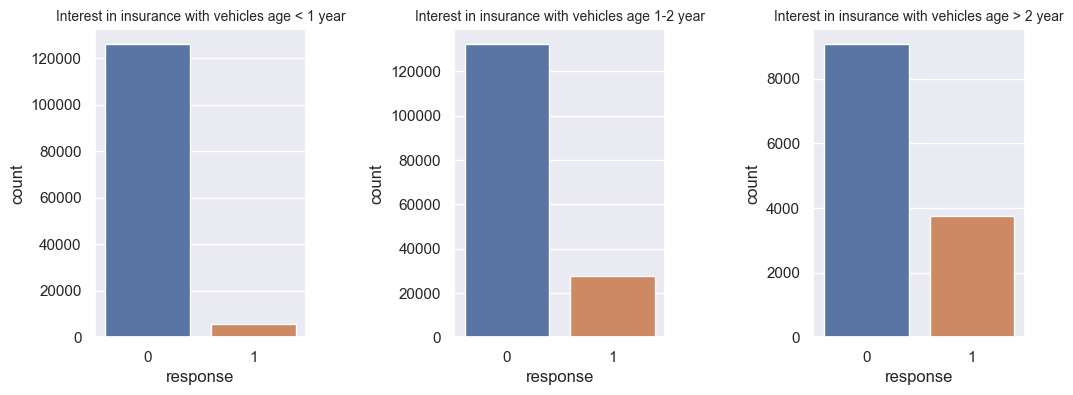

In [36]:
#Vehicles
fig, ax = plt.subplots(1,3,figsize=(12,4))

aux = df4[df4['vehicle_age']=='< 1 Year']
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance with vehicles age < 1 year", fontsize=10);

aux = df4[df4['vehicle_age']=='1-2 Year']
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance with vehicles age 1-2 year", fontsize=10);

aux = df4[df4['vehicle_age']=='> 2 Years']
sns.countplot(data=aux, x='response', ax=ax[2])
ax[2].set_title("Interest in insurance with vehicles age > 2 year", fontsize=10);

plt.subplots_adjust(wspace=0.7)

Hypothesis is true, clients with older vehicles has more intereset in adquiring insurance

- Vehicles that got damaged have more probability to adquire insurance

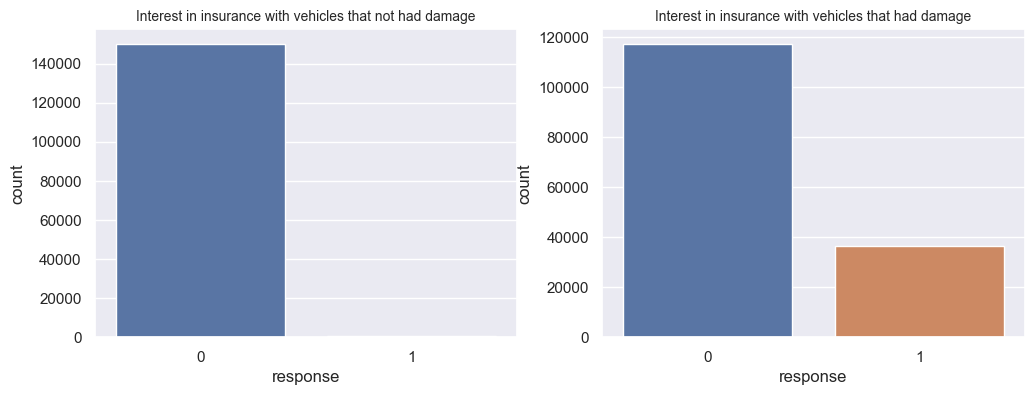

In [37]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['vehicle_damage']==0]
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance with vehicles that not had damage", fontsize=10);

aux = df4[df4['vehicle_damage']==1]
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance with vehicles that had damage", fontsize=10);

Hypothesis is true, clients with vehicles that had damage have more interest in adquire insurance

- Vehicles that already had an insurance have more probability to adquire insurance

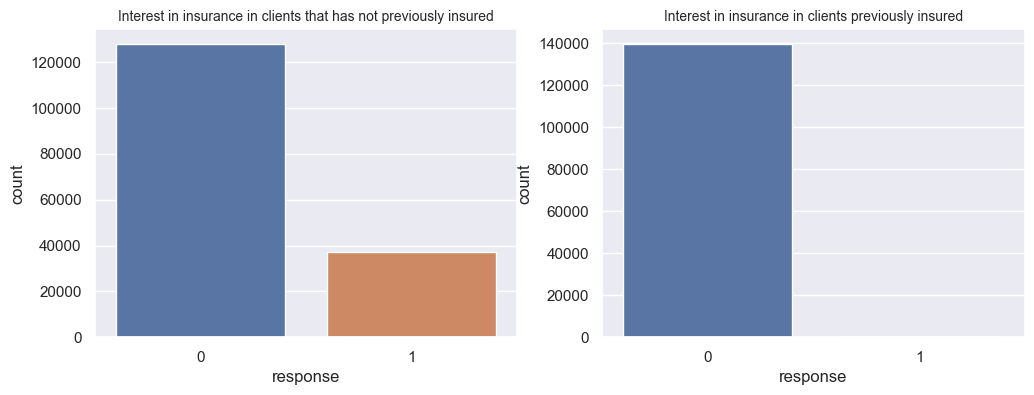

In [38]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['previously_insured']==0]
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance in clients that has not previously insured", fontsize=10);

aux = df4[df4['previously_insured']==1]
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance in clients previously insured", fontsize=10);

Hypothesis is false, clients previously insured have less intereset in adquiring insurance

- Health Insurance
    - Higher premium have more probability to adquire insurance

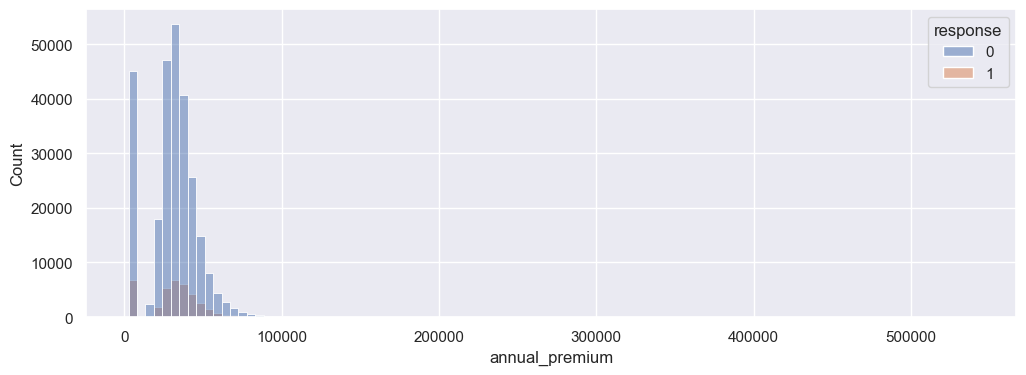

In [39]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(x='annual_premium', hue='response', data=df4, bins=100, ax=ax);

Hypothesis is false, clients with higher annual premium have less interest in insurance

- More days associeted have more probability to adquire insurance


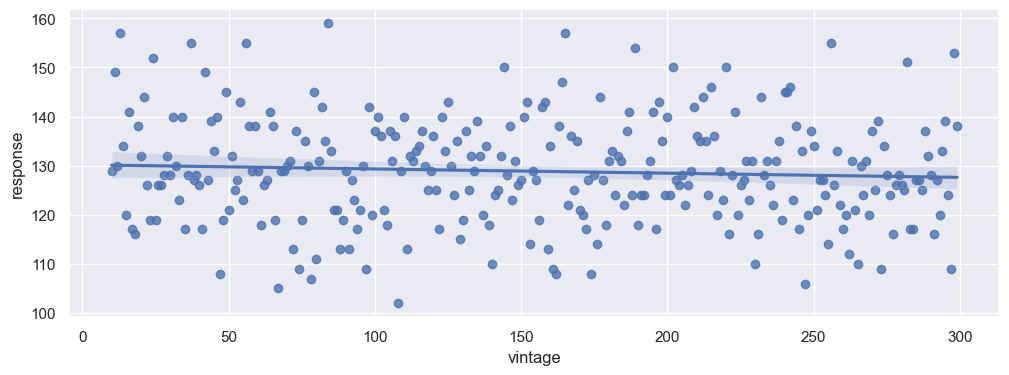

In [40]:
fig, ax = plt.subplots(figsize=(12,4))
aux = df4[['vintage', 'response']].groupby('vintage').sum().reset_index()
sns.regplot(x='vintage', y='response', data=aux, ax=ax);

Hypotehsis is false, clients with more days associeted have less intereset in insurance

- Customer
    - Higher age have more probability to adquire insurance

<Axes: xlabel='response', ylabel='age'>

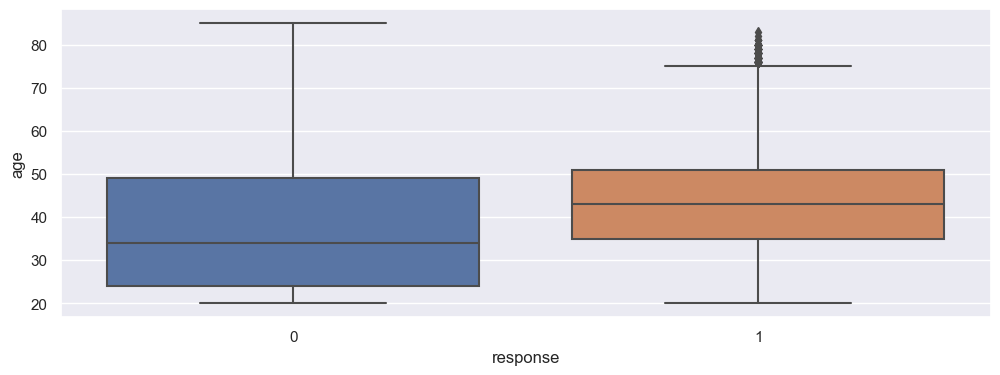

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x='response', y='age', data=df4, ax=ax)

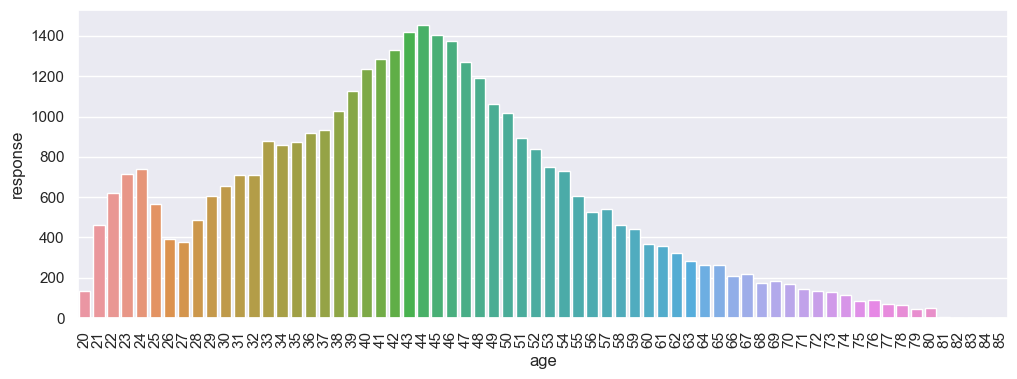

In [42]:
fig, ax = plt.subplots(figsize=(12,4))
aux = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux, ax=ax)
plt.xticks( rotation=90 );

Hypothesis is false, customers with higher age have less interest in insurance

- Female gender have more probability to adquire insurance

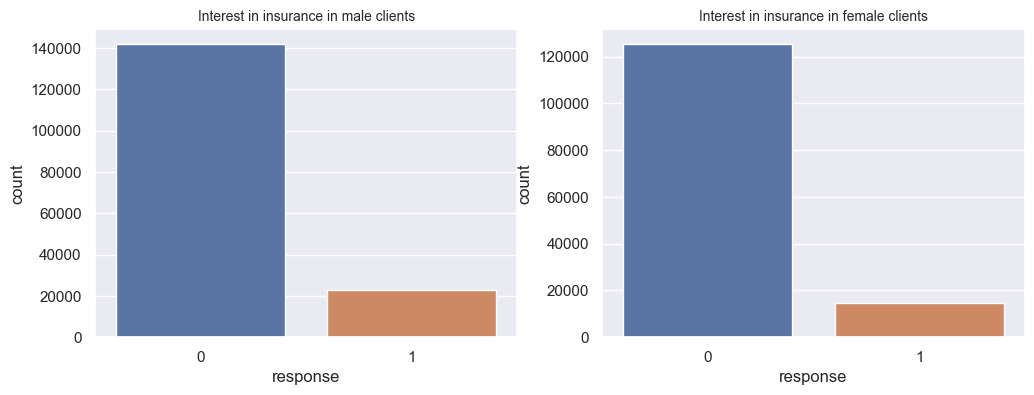

In [43]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

aux = df4[df4['gender']=='Male']
sns.countplot(data=aux, x='response', ax=ax[0])
ax[0].set_title("Interest in insurance in male clients", fontsize=10);

aux = df4[df4['gender']=='Female']
sns.countplot(data=aux, x='response', ax=ax[1])
ax[1].set_title("Interest in insurance in female clients", fontsize=10);

In [44]:
df4

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,25455.0,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,38393.0,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,32118.0,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,37711.0,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,48706.0,156,222,0
...,...,...,...,...,...,...,...,...,...,...,...,...
378816,378817,Male,25,1,47,1,< 1 Year,1,23010.0,160,58,0
67726,67727,Male,69,1,28,0,1-2 Year,1,31630.0,26,290,1
91744,91745,Male,24,1,28,0,< 1 Year,0,59094.0,152,62,0
48700,48701,Female,40,1,8,1,1-2 Year,0,28940.0,26,262,0


### 4.2.x Hipothesis validation

### 4.2.y Hipothesis resume

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

### 4.3.2 Categorical attributes

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalization

In [46]:
# annual_premium -> StandardScaler
ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

In [47]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
274710,274711,Male,22,1,40,0,< 1 Year,1,-0.297943,152,203,0
216539,216540,Female,26,1,8,1,< 1 Year,0,0.452554,26,45,0
78983,78984,Female,32,1,28,0,< 1 Year,1,0.088559,122,35,1
218368,218369,Male,32,1,37,0,< 1 Year,1,0.412993,152,215,0
307215,307216,Female,24,1,28,0,< 1 Year,1,1.050781,156,222,0


## 5.2 Rescaling

In [48]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3 Encoding

In [49]:
# gender
gender_target = df5[['gender', 'response']].groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(gender_target)

# region code
region_encoder = df5[['region_code', 'response']].groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(region_encoder)

# vehicle_age
age_dict = {'< 1 Year':'below_1_year', '1-2 Year':'between_1_2_year', '> 2 Years':'above_2_year'}
df5['vehicle_age'] = df5['vehicle_age'].map(age_dict)

df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_chanel
policy_encoder = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(policy_encoder)

## 5.4 Test preparation

In [50]:
df_test

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
16221,16222,Male,54,1,28,0,> 2 Years,Yes,75219.0,26,53,1
342480,342481,Female,26,1,3,0,1-2 Year,Yes,19738.0,156,280,0
20915,20916,Male,25,1,28,0,< 1 Year,Yes,61524.0,124,255,0
38703,38704,Male,29,1,24,0,1-2 Year,Yes,2630.0,157,235,1
363808,363809,Female,28,1,28,0,< 1 Year,Yes,51473.0,26,243,1
...,...,...,...,...,...,...,...,...,...,...,...,...
151614,151615,Male,40,1,28,0,1-2 Year,Yes,32747.0,124,140,0
170170,170171,Female,39,1,48,0,1-2 Year,No,2630.0,124,178,0
303221,303222,Male,60,1,28,0,1-2 Year,Yes,36965.0,26,285,0
333829,333830,Male,23,1,15,1,< 1 Year,No,28270.0,152,98,0


In [51]:
df_test['vehicle_damage'] = df_test['vehicle_damage'].map(damage)

# annual_premiu -> StandardScaler
df_test['annual_premium'] = ss.fit_transform(df_test[['annual_premium']].values)

# age
df_test['age'] = mms_age.fit_transform(df_test[['age']].values)

# vintage
df_test['vintage'] = mms_vintage.fit_transform(df_test[['vintage']].values)

# gender
df_test['gender'] = df_test['gender'].map(gender_target)

# region code
df_test['region_code'] = df_test['region_code'].map(region_encoder)

# vehicle_age
df_test['vehicle_age'] = df_test['vehicle_age'].map(age_dict)

df_test = pd.get_dummies(df_test, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_chanel
df_test['policy_sales_channel'] = df_test['policy_sales_channel'].map(policy_encoder)

In [52]:
df_test.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            1
vintage                         0
response                        0
vehicle_age_above_2_year        0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
dtype: int64

In [53]:
df_test.loc[df_test['policy_sales_channel'].isna()]

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_above_2_year,vehicle_age_below_1_year,vehicle_age_between_1_2_year
279714,279715,0.138069,0.723077,1,0.187042,1,0,0.162457,NaN,0.968858,0,0,0,1


In [54]:
df_test = df_test.drop(index = [279714])

In [55]:
y_test = df_test['response']
X_test = df_test.drop('response', axis=1)

# 6.0 Feature selection

In [56]:
df6 = df5.copy()

## 6.1 Splitting dataframe for validation

In [57]:
X = df6.drop(['response', 'id'], axis = 1).copy() # 304887 rows × 12 columns
y = df6['response'].copy() #Length: 304887

#Split Train into Val:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

## 6.2 Extra Trees as Feature Selector

In [58]:
extra_trees = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

In [59]:
# data preparation
x_train_n = X_train 
y_train_n = y_train.values
extra_trees.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.271046
0                annual_premium    0.242200
0                           age    0.169291
0                   region_code    0.104967
0                vehicle_damage    0.067514
0          policy_sales_channel    0.061199
0            previously_insured    0.056447
0      vehicle_age_below_1_year    0.013654
0  vehicle_age_between_1_2_year    0.005955
0                        gender    0.004747
0      vehicle_age_above_2_year    0.002441
0               driving_license    0.000539


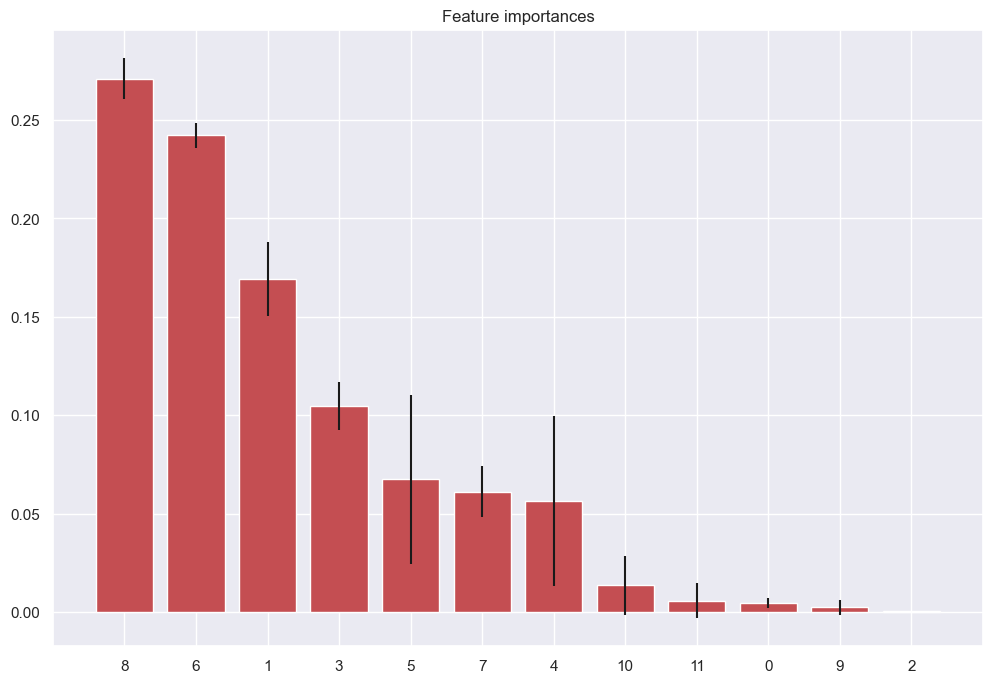

In [60]:
importances = extra_trees.feature_importances_
std = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, extra_trees.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

## 6.3 Manual feature selection

Let's select the 7 best features by the ExtraTreesClassifier and then we will check the performance with them

In [61]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [62]:
# New data with selected columns by the ExtraTrees
X_train = X_train[cols_selected]
X_val = X_val[cols_selected]

# 7.0 Machine Learning Modelling - First steps

In the first steps of machine learning modelling we will evaluate three models comparing their performance, 
then with the best model we will run a more detailed analysis through cross validation and hyperparameter tuning.

## 7.1 KNN

In [63]:
# Model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=8)

# Model training
knn_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_knn = knn_model.predict_proba( X_val );

# Model prediction
yhat_predict_knn = knn_model.predict(X_val);

## 7.2 Logistic Regression

In [64]:
# Model definition
lr_model = lm.LogisticRegression(class_weight='balanced', random_state=42)

# Model training
lr_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lr = lr_model.predict_proba(X_val)

# Model prediction
yhat_predict_lr = lr_model.predict(X_val)

## 7.3 LGBM

In [131]:
# Model definition
lgbm_model = LGBMClassifier(random_state=42, verbose = -1)

# Model training
lgbm_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lgbm = lgbm_model.predict_proba(X_val);

# Model prediction
yhat_predict_lgbm = lgbm_model.predict(X_val);

## 7.4 ExtraTrees

In [66]:
# Model definition
et_model = en.ExtraTreesClassifier(n_estimators=100, random_state=30, n_jobs=-1)

# Model training
et_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_et = et_model.predict_proba( X_val );

# Model prediction
yhat_predict_et = et_model.predict(X_val);

## 7.5 XGBoost Classifier

In [67]:
# Model definition
xgb_model = xgb(n_estimators=100, random_state=30, n_jobs=-1)

# Model training
xgb_model.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_xgb = xgb_model.predict_proba( X_val );

# Model prediction
yhat_predict_xgb = xgb_model.predict(X_val);

## 7.6 Models Evaluation


In [68]:
# Define the value of the k using 40% of the base
k = int(X_val.shape[0]*0.4)

### 7.6.1 KNN

#### Accuracy, Precision and Recall

In [69]:
accuracy_knn = accuracy_score(y_val, yhat_predict_knn)

precision_knn = precision_score(y_val, yhat_predict_knn)

recall_knn = recall_score(y_val, yhat_predict_knn)

#### Cumulative Gain and Lift Curve

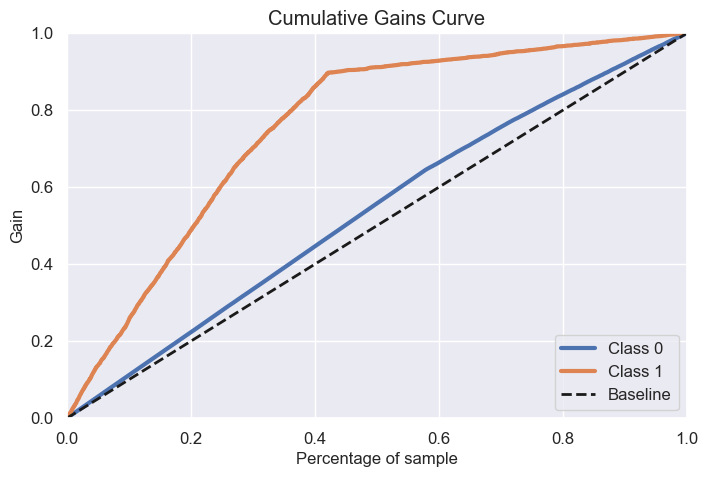

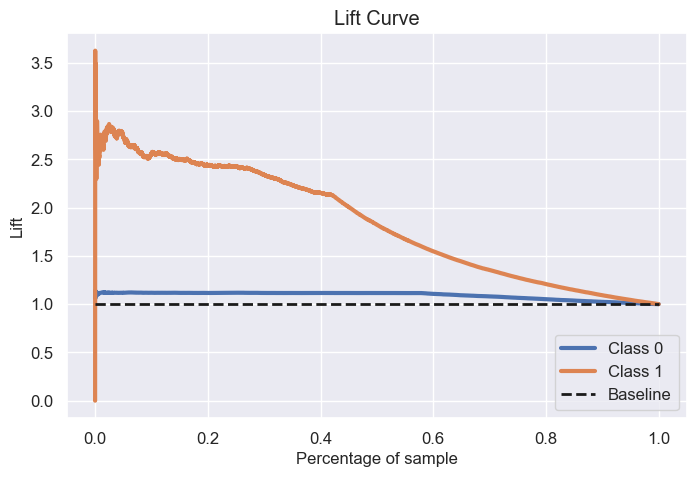

In [70]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_knn, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_knn, figsize = (8,5));

#### Precision@k and Recall@k

In [71]:
metrics_knn, table_knn = precision_recall_at_k(yhat_proba_knn, y_val, 2000)

In [72]:
print(f'Precision at K: {metrics_knn[0]}')
print(f'Recall at K: {metrics_knn[1]}')

Precision at K: 0.3225
Recall at K: 0.1725983409151726


#### Results

In [73]:
knn_results = pd.DataFrame({
    'Model Name':'KNN Classifier',
    'Accuracy':accuracy_knn, 
    'Precision':precision_knn, 
    'Recall':recall_knn, 
    'Precision@K':metrics_knn[0], 
    'Recall@K':metrics_knn[1]
}, index=[0])

### 7.6.2 Logistic Regression

#### Accuracy, Precision and Recall

In [74]:
accuracy_lr = accuracy_score(y_val, yhat_predict_lr)

precision_lr = precision_score(y_val, yhat_predict_lr)

recall_lr = recall_score(y_val, yhat_predict_lr)

#### Cumulative Gain and Lift Curve

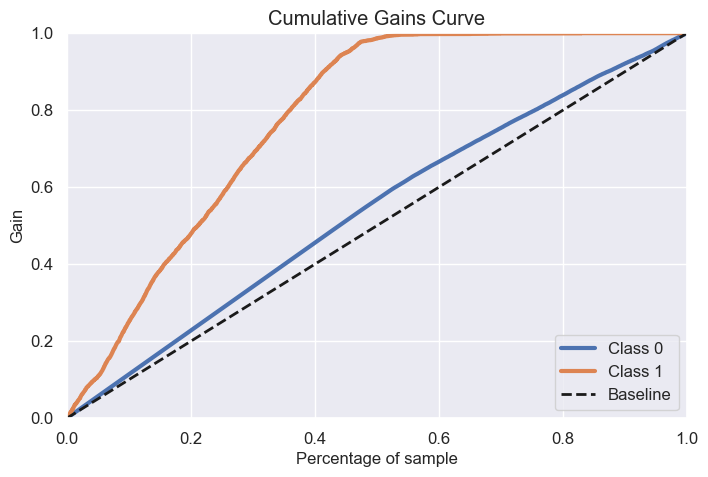

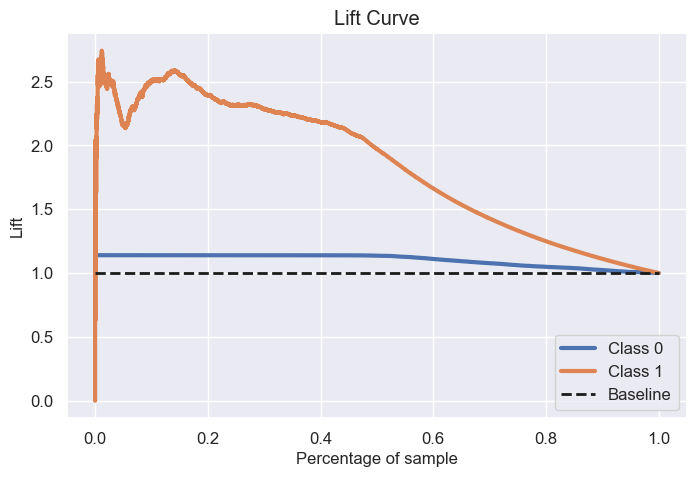

In [75]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lr, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lr, figsize = (8,5));

#### Precision@k and Recall@k

In [76]:
metrics_lr, table_lr = precision_recall_at_k(yhat_proba_lr, y_val, k)

In [77]:
print(f'Precision at K: {metrics_lr[0]}')
print(f'Recall at K: {metrics_lr[1]}')

Precision at K: 0.26756867568675685
Recall at K: 0.8731602890018731


#### Results

In [78]:
lr_results = pd.DataFrame({
    'Model Name':'Logistic Regression Classifier',
    'Accuracy':accuracy_lr, 
    'Precision':precision_lr, 
    'Recall':recall_lr, 
    'Precision@K':metrics_lr[0], 
    'Recall@K':metrics_lr[1]
}, index=[0])

### 7.6.3 LGBMClassifier

#### Accuracy, Precision and Recall

In [79]:
accuracy_lgbm = accuracy_score(y_val, yhat_predict_lgbm)

precision_lgbm = precision_score(y_val, yhat_predict_lgbm)

recall_lgbm = recall_score(y_val, yhat_predict_lgbm)

#### Cumulative Gain and Lift Curve

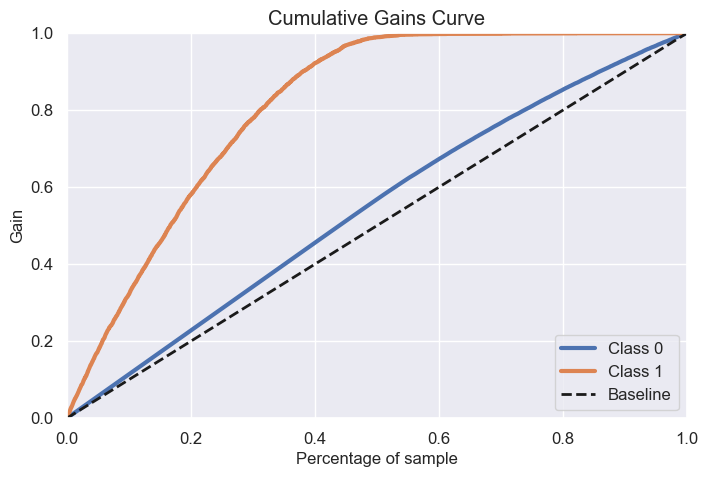

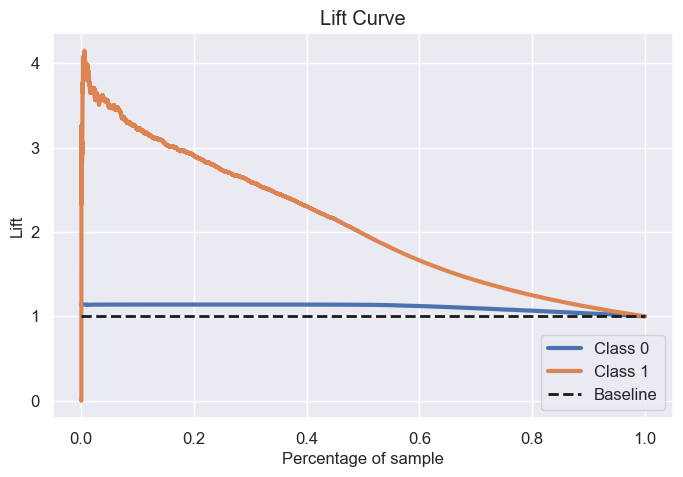

In [80]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm, figsize = (8,5));

#### Precision@k and Recall@k

In [81]:
metrics_lgbm, table_lgbm = precision_recall_at_k(yhat_proba_lgbm, y_val, k)

In [82]:
print(f'Precision at K: {metrics_lgbm[0]}')
print(f'Recall at K: {metrics_lgbm[1]}')

Precision at K: 0.2825748257482575
Recall at K: 0.9221300508429221


#### Results

In [83]:
lgbm_results = pd.DataFrame({
    'Model Name':'LBGM Classifier',
    'Accuracy':accuracy_lgbm, 
    'Precision':precision_lgbm, 
    'Recall':recall_lgbm, 
    'Precision@K':metrics_lgbm[0], 
    'Recall@K':metrics_lgbm[1]
}, index=[0])

### 7.6.4 ExtraTrees

#### Accuracy, Precision and Recall

In [84]:
accuracy_et = accuracy_score(y_val, yhat_predict_et)

precision_et = precision_score(y_val, yhat_predict_et)

recall_et = recall_score(y_val, yhat_predict_et)

#### Cumulative Gain and Lift Curve

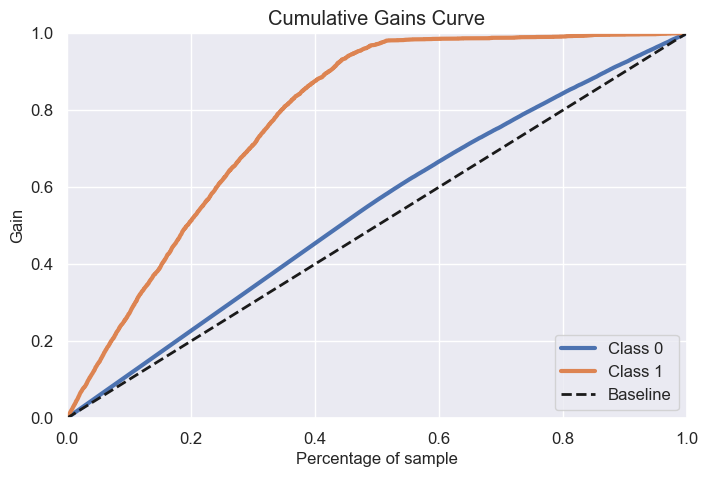

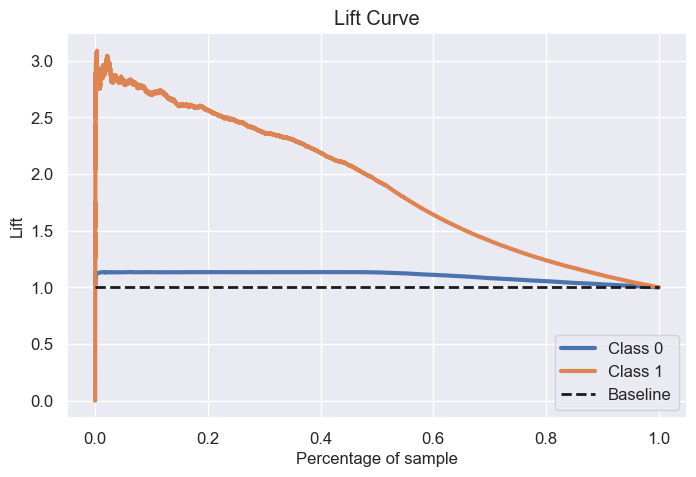

In [85]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_et, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_et, figsize = (8,5));

#### Precision@k and Recall@k

In [86]:
metrics_et, table_et = precision_recall_at_k(yhat_proba_et, y_val, k)

In [87]:
print(f'Precision at K: {metrics_et[0]}')
print(f'Recall at K: {metrics_et[1]}')

Precision at K: 0.26838868388683884
Recall at K: 0.8758362322718758


#### Results

In [88]:
et_results = pd.DataFrame({
    'Model Name':'ExtraTrees Classifier',
    'Accuracy':accuracy_et, 
    'Precision':precision_et, 
    'Recall':recall_et, 
    'Precision@K':metrics_et[0], 
    'Recall@K':metrics_et[1]
}, index=[0])

### 7.6.5 XGBoostClassifier

#### Accuracy, Precision and Recall

In [89]:
accuracy_xgb = accuracy_score(y_val, yhat_predict_xgb)

precision_xgb = precision_score(y_val, yhat_predict_xgb)

recall_xgb = recall_score(y_val, yhat_predict_xgb)

#### Cumulative Gain and Lift Curve

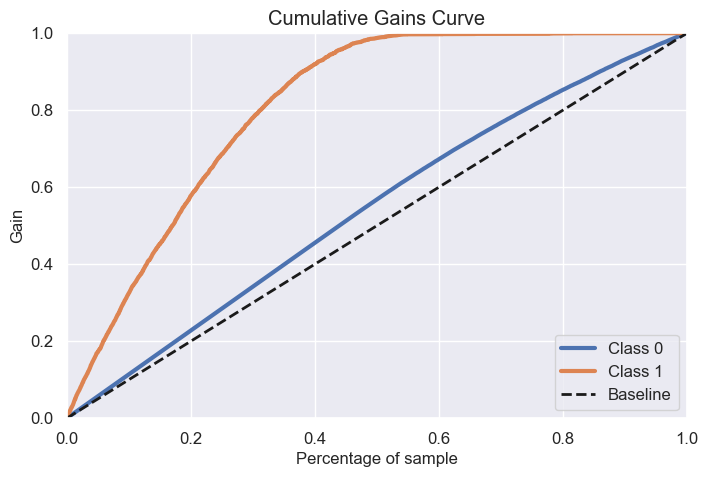

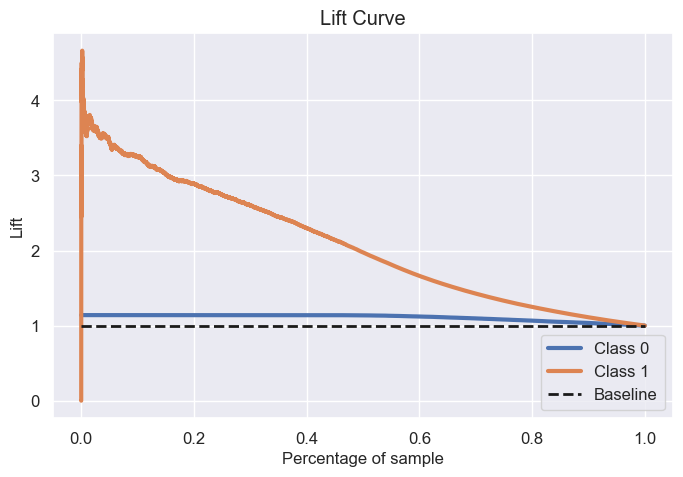

In [90]:
# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_xgb, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_xgb, figsize = (8,5));

#### Precision@k and Recall@k

In [91]:
metrics_xgb, table_xgb = precision_recall_at_k(yhat_proba_xgb, y_val, k)

In [92]:
print(f'Precision at K: {metrics_xgb[0]}')
print(f'Recall at K: {metrics_xgb[1]}')

Precision at K: 0.2816728167281673
Recall at K: 0.9191865132459192


#### Results

In [93]:
xgb_results = pd.DataFrame({
    'Model Name':'XGBoost Classifier',
    'Accuracy':accuracy_xgb, 
    'Precision':precision_xgb, 
    'Recall':recall_xgb, 
    'Precision@K':metrics_xgb[0], 
    'Recall@K':metrics_xgb[1]
}, index=[0])

### 7.6.6 Results

#### Performance

In [94]:
results = pd.concat([knn_results, lr_results, lgbm_results, et_results, xgb_results])

results.sort_values(by = 'Recall@K', ascending = False)

,Model Name,Accuracy,Precision,Recall,Precision@K,Recall@K
0,LBGM Classifier,0.877234,0.384615,0.002676,0.282575,0.922130
0,XGBoost Classifier,0.876939,0.456140,0.020872,0.281673,0.919187
0,ExtraTrees Classifier,0.860802,0.343228,0.148515,0.268389,0.875836
0,Logistic Regression Classifier,0.641674,0.252104,0.978057,0.267569,0.873160
0,KNN Classifier,0.869756,0.348837,0.072250,0.322500,0.172598


#### Cumulative gain curves

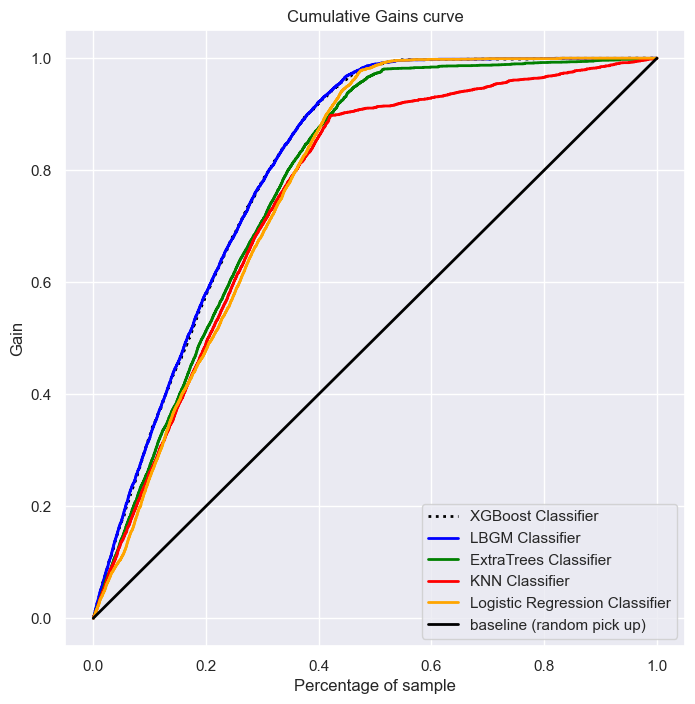

In [95]:
# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(ax = axes, x = table_xgb['cumulative_porc_base'], y = table_xgb['cumulative_propensity_score'], label="XGBoost Classifier", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = table_lgbm['cumulative_porc_base'], y = table_lgbm['cumulative_propensity_score'], label="LBGM Classifier", linewidth = 2, color = 'blue')
sns.lineplot(ax = axes, x = table_et['cumulative_porc_base'], y = table_et['cumulative_propensity_score'], label="ExtraTrees Classifier", linewidth = 2, color = 'green')
sns.lineplot(ax = axes, x = table_knn['cumulative_porc_base'], y = table_knn['cumulative_propensity_score'], label="KNN Classifier", linewidth = 2, color = 'red')
sns.lineplot(ax = axes, x = table_lr['cumulative_porc_base'], y = table_lr['cumulative_propensity_score'], label="Logistic Regression Classifier", linewidth = 2, color = 'orange')
sns.lineplot(ax = axes, x = table_xgb['cumulative_porc_base'], y = table_xgb['cumulative_porc_base'], label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")

axes.legend()
axes.set_title("Cumulative Gains curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Gain")

axes.plot;

#### Lift curves

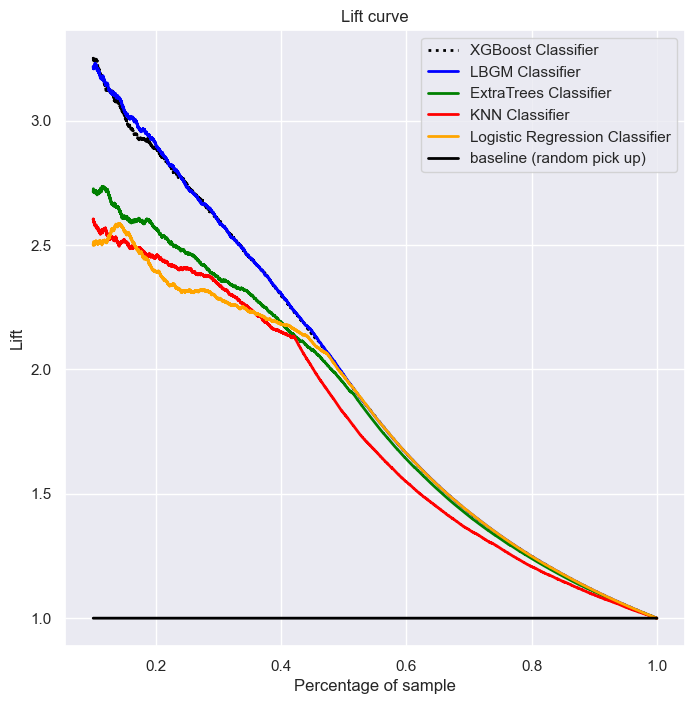

In [96]:
lift_xgb = table_xgb.query('cumulative_porc_base >= 0.1')
lift_lgbm = table_lgbm.query('cumulative_porc_base >= 0.1')
lift_et = table_et.query('cumulative_porc_base >= 0.1')
lift_knn = table_knn.query('cumulative_porc_base >= 0.1')
lift_lr = table_lr.query('cumulative_porc_base >= 0.1')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.lineplot(ax = axes, x = lift_xgb['cumulative_porc_base'], y = lift_xgb['lift'], label="XGBoost Classifier", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = lift_lgbm['cumulative_porc_base'], y = lift_lgbm['lift'], label="LBGM Classifier", linewidth = 2, color = 'blue')
sns.lineplot(ax = axes, x = lift_et['cumulative_porc_base'], y = lift_et['lift'], label="ExtraTrees Classifier", linewidth = 2, color = 'green')
sns.lineplot(ax = axes, x = lift_knn['cumulative_porc_base'], y = lift_knn['lift'], label="KNN Classifier", linewidth = 2, color = 'red')
sns.lineplot(ax = axes, x = lift_lr['cumulative_porc_base'], y = lift_lr['lift'], label="Logistic Regression Classifier", linewidth = 2, color = 'orange')
sns.lineplot(ax = axes, x = lift_xgb['cumulative_porc_base'], y = np.ones(len(lift_xgb)), label="baseline (random pick up)", linewidth = 2, color = 'black')



axes.lines[0].set_linestyle(":")

axes.legend()
axes.set_title("Lift curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Lift")

axes.plot;

## 7.7 Cross validation

### 7.7.1 KNN

In [109]:
knn_cv_metrics = cross_validation(knn_model, "KNN Classifier", X_train, y_train, k, 5)

knn_cv_metrics

,Model name,precision_at_k,recall_at_k
0,KNN Classifier,0.299+/-0.0022,0.5422+/-0.0041


### 7.7.2 Logistic Regression

In [112]:
lr_cv_metrics = cross_validation(lr_model, "LogisticRegression Classifier", X_train, y_train, k, 5)

lr_cv_metrics

,Model name,precision_at_k,recall_at_k
0,LogisticRegression Classifier,0.2856+/-0.0017,0.5179+/-0.0031


### 7.7.3 LBGM

In [132]:
lgbm_cv_metrics = cross_validation(lgbm_model, "LGBM Classifier", X_train, y_train, k, 5)

lgbm_cv_metrics

,Model name,precision_at_k,recall_at_k
0,LGBM Classifier,0.343+/-0.0027,0.6219+/-0.0049


### 7.7.4 ExtraTrees

In [113]:
et_cv_metrics = cross_validation(et_model, "ExtraTrees Classifier", X_train, y_train, k, 5)

et_cv_metrics

,Model name,precision_at_k,recall_at_k
0,ExtraTrees Classifier,0.3097+/-0.0018,0.5615+/-0.0032


###  7.7.5 XGB Classifier

In [114]:
xgb_cv_metrics = cross_validation(xgb_model, "XGBoost Classifier", X_train, y_train, k, 5)

xgb_cv_metrics

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.3405+/-0.0012,0.6173+/-0.0022


### 7.7.6 Results

In [115]:
results_cv = pd.concat([knn_cv_metrics, lr_cv_metrics, lgbm_cv_metrics, et_cv_metrics, xgb_cv_metrics])

results_cv.sort_values(by = 'recall_at_k', ascending = False)

,Model name,precision_at_k,recall_at_k
0,LGBM Classifier,0.343+/-0.0027,0.6219+/-0.0049
0,XGBoost Classifier,0.3405+/-0.0012,0.6173+/-0.0022
0,ExtraTrees Classifier,0.3097+/-0.0018,0.5615+/-0.0032
0,KNN Classifier,0.299+/-0.0022,0.5422+/-0.0041
0,LogisticRegression Classifier,0.2856+/-0.0017,0.5179+/-0.0031


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random search

In [183]:
param = {'learning_rate':[1e-3, 1e-1],
         'num_leaves':[2, 20, 50, 100, 120],
         'min_child_samples':[1, 5, 10, 25, 50, 75, 100],
         'subsample':[0.05, 0.10, 0.25, 0.50, 0.75, 1.0],
         'colsample_bytree':[0.1, 0.5, 0.7, 1.0],
        }

MAX_EVAL = 5

In [195]:
final_result = pd.DataFrame()
hyperparam_lst = []

for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
    #print the selected ones
    print(hp)
    #store in list
    hyperparam_lst.append(hp.copy())
    #model
    model_lgbm = LGBMClassifier(learning_rate=hp['learning_rate'],
                               num_leaves=hp['num_leaves'],
                               min_child_samples=hp['min_child_samples'],
                               subsample=hp['subsample'],
                               colsample_bytree=hp['colsample_bytree'],
                               random_state=0, 
                               subsample_freq=1,
                               n_estimators=1000,
                               verbose=-1,
                               class_weight='balanced'
                               )
    result = cross_validation(model_lgbm, 'LBGM Classifier', X_train, y_train, k, 5)
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result = pd.concat([final_result, result_w_nr], ignore_index=True)

final_result.sort_values(by=['precision_at_k'], ascending=False, inplace=True, ignore_index=True)
final_result

{'learning_rate': 0.001, 'num_leaves': 120, 'min_child_samples': 100, 'subsample': 0.1, 'colsample_bytree': 0.7}
{'learning_rate': 0.001, 'num_leaves': 50, 'min_child_samples': 50, 'subsample': 0.25, 'colsample_bytree': 1.0}
{'learning_rate': 0.1, 'num_leaves': 120, 'min_child_samples': 1, 'subsample': 0.5, 'colsample_bytree': 0.7}
{'learning_rate': 0.1, 'num_leaves': 100, 'min_child_samples': 25, 'subsample': 0.75, 'colsample_bytree': 0.7}
{'learning_rate': 0.001, 'num_leaves': 20, 'min_child_samples': 100, 'subsample': 0.05, 'colsample_bytree': 0.7}


,Model name,precision_at_k,recall_at_k,Iter_nr
0,LBGM Classifier,0.3429+/-0.0038,0.6217+/-0.0068,0
1,LBGM Classifier,0.3418+/-0.0036,0.6198+/-0.0064,4
2,LBGM Classifier,0.3417+/-0.0033,0.6195+/-0.006,1
3,LBGM Classifier,0.3257+/-0.0025,0.5905+/-0.0046,3
4,LBGM Classifier,0.3024+/-0.0129,0.5483+/-0.0234,2


In [188]:
# select the hyperparameters that resulted in best accuracy
best_param_nr = final_result.loc[0, 'Iter_nr']

param_tuned = hyperparam_lst[best_param_nr]

param_tuned

{'learning_rate': 0.001,
 'num_leaves': 100,
 'min_child_samples': 75,
 'subsample': 0.1,
 'colsample_bytree': 0.5}

## 8.2 - Final model

In [189]:
# Model tuned
model_lgbm_tuned = LGBMClassifier(learning_rate=param_tuned['learning_rate'],
                               num_leaves=param_tuned['num_leaves'],
                               min_child_samples=param_tuned['min_child_samples'],
                               subsample=param_tuned['subsample'],
                               colsample_bytree=param_tuned['colsample_bytree'],
                               random_state=0, 
                               subsample_freq=1,
                               n_estimators=1000,
                               verbose=-1,
                               class_weight='balanced'
                               )

In [191]:
# Model training
model_lgbm_tuned.fit(X_train, y_train.values.ravel())

# Model prediction (proba)
yhat_proba_lgbm = model_lgbm_tuned.predict_proba(X_val);

# Model prediction
yhat_predict_lgbm = model_lgbm_tuned.predict(X_val);

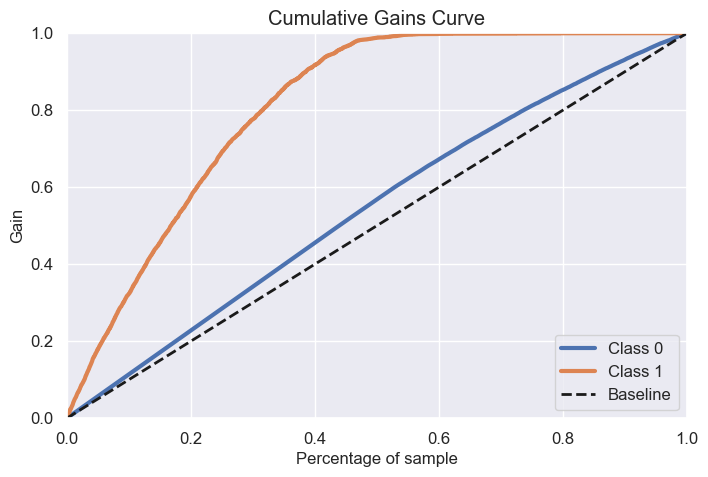

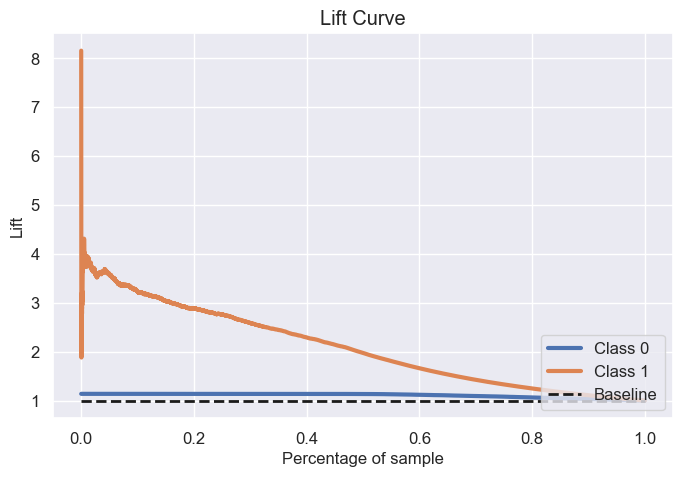

In [192]:
# Accuracy
accuracy_lgbm = accuracy_score(y_val, yhat_predict_lgbm)

# Precision
precision_lgbm = precision_score(y_val, yhat_predict_lgbm)

# Recall
recall_lgbm = recall_score(y_val, yhat_predict_lgbm)

# Cumulative Gain Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_lgbm, figsize = (8,5));

# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm, figsize = (8,5));

# Precision@k and Recall@k
metrics_lgbm, table_lgbm = precision_recall_at_k(yhat_proba_lgbm, y_val, k)

# Join results
lgbm_results = pd.DataFrame({
    'Model Name':'LBGM Classifier',
    'Accuracy':accuracy_lgbm, 
    'Precision':precision_lgbm, 
    'Recall':recall_lgbm, 
    'Precision@K':metrics_lgbm[0], 
    'Recall@K':metrics_lgbm[1]
}, index=[0])

In [193]:
lgbm_results

,Model Name,Accuracy,Precision,Recall,Precision@K,Recall@K
0,LBGM Classifier,0.702056,0.28095,0.917581,0.280853,0.916511
